# Домашнее задание
Дообучение энкодер-декодерных моделей

**Цель:**

В данном домашнем задании мы продолжаем работать с датасетами отзывов о ресторанах, но теперь вам предстоит сравнить различные энкодер-декодерные модели.

**Описание / пошаговая инструкция выполнения домашнего задания:**


1. **Разделение данных на train/val/test:**

- В дополнительных материалах к уроку найдите датасет с отзывами о ресторанах (restaurants_reviews.jsonl).
- Разбейте данные на train/val/test, отложив по 15% в test и val. Не забудьте зафиксировать random_state.
- В качестве целевой переменной возьмите общий отзыв из колонки general.
- Оставьте только отзывы с рейтингом general равным 1, 3 и 5. Для удобства перекодируйте лейблы 1, 3 и 5 в метки 0, 1, 2.

2. **Дообучение энкодер-декодерных моделей:**
- Возьмите модели:
    - https://huggingface.co/ai-forever/ruT5-base или https://huggingface.co/ai-forever/ruT5-large
    - https://huggingface.co/google/mt5-small или https://huggingface.co/google/mt5-base или https://huggingface.co/google/mt5-large
- Каждую дообучите на train части данных. Обучение продолжайте до выхода модели на плато на валидации.
- Возьмите итоговый чекпоинт (версию, с минимальным loss на валидации) и замерьте качество на test (в качестве метрики используйте accuracy).
  
3. **Анализ результатов:**

- Составьте таблицу с результатами моделей, количеством эпох, которое обучается модель до достижения минимум на валидации, время, затрачиваемое на итерацию, и общее время дообучения.
- Проведите анализ полученных результатов, опишите выводы в MarkDown.



In [3]:
import gc, time
import pandas as pd
pd.options.display.max_colwidth = 300

import numpy as np
import torch
from tqdm.auto import tqdm, trange

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from torch.optim import Adam
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

## 1. Обработка данных

В дополнительных материалах к уроку найдите датасет с отзывами о ресторанах (restaurants_reviews.jsonl)

In [5]:
df = pd.read_json('./data/restaurants_reviews.jsonl', lines=True)
df

,review_id,general,food,interior,service,text
0,0,0,10,10,10,"Вытянули меня сегодня в город и раз уж была в районе Садовой , решила заехать на тартар в Винсент . Теперь могу спокойно жить дальше - отпустило )) Практически в дверях встречают улыбчивые девушки , интересуются наличием вредных привычек и провожают к столику . Ну , сразу скажу , что мне очень..."
1,1,0,9,10,9,"проводили корпоратив на 60 чел. в этот - уже третий раз все было здорово , возможно организаторы объективно восприняли критику от 26.09.2011 ( читайте мой отзыв ) , а возможно и сами поняли что работать надо с душой , лицом к клиенту и поменялись ..... не знаю что произошло , но изменения в лучш..."
2,2,0,9,10,10,"Был в Гостях с женой один раз и еще раз с женой и другом . Очень прикольный интерьер . Официанты очень хорошо обслуживают . Я бы даже сказал виртуозно , обслуживал нас молодой человек ( к сожалению не запомнил как его зовут ) , который буквально порхал с подносом и предугадывал наши вопросы и..."
3,3,0,-,5,10,"Бар понравился на первый взгляд . Интерьер к достоинствам бара я не отнесу , но коктейли интересные , обслуживание доброжелательное , быстрое . Цены средние : практически любой коктейль - 350р , набор из 4х шотов на основе джина ( например ) - 600р . Есть безалкогольные напитки - домашние лим..."
4,4,0,7,10,10,"В « Bel Canto » мы отмечали юбилей моего отца . К сожалению , я опоздал и не застал начало мероприятия . Встретили очень хорошо вежливо и с улыбкой . Сев за стол был приятно удивлен оформлением стола . Официанты молодые люди ( парни ) , что бывает довольно редко . Их было не видно и ни кто ..."
...,...,...,...,...,...,...
47134,47134,0,0,0,0,"Большое спасибо Ирине - за организацию , официантам - за оперативность , аккуратность и улыбчивость и поварам - за мастерство ( все гости отметили вкусно приготовленные блюда - начиная от канапе и заканчивая горячим ) . Все было на высшем уровне . Зал был оформлен очень красиво , отдельное спа..."
47135,47135,0,0,0,0,"В данном заведении мы частые гости и всегда советуем его своим знакомым и друзьям , т. к. в Райском дворике действительно красиво , уютно , а готовят ну просто великолепно . 11 мая 2012г . в 17-00 мы с мужем пришли отметить вдвоем его день рождения в данное заведение Райский дворик . Обслуживал..."
47136,47136,0,0,0,0,"07/05/2012 Отмечали здесь свадьбу и остались очень довольны . Нареканий нет ни к кухне , ни к персоналу , ни к интерьеру . Огромное спасибо управляющей Нине Георгиевне , всему персоналу за организацию нашего праздника . Помогли и советом ( при выборе меню , при рассадке гостей ) и делом , как..."
47137,47137,0,0,0,0,"Были проездом в Москве , заглянули с коллегой в Колбасофф на Павелецкой . Заказали нефильтрованного темного и подкопченные мюнхенские колбаски . От последних аппетитно пахло живым костром . Короче , нам понравилось !"


Оставьте только отзывы с рейтингом general равным 1, 3 и 5.

In [7]:
df[df['general'].isin([1,3,5])]['general'].value_counts()

general
5    2164
1     462
3     150
Name: count, dtype: int64

In [8]:
df[df['general'].isin([1,3,5])]['general'].value_counts().sum()

2776

In [9]:
df = df[df['general'].isin([1,3,5])]
df['general'].value_counts()

general
5    2164
1     462
3     150
Name: count, dtype: int64

Для удобства перекодируйте лейблы 1, 3 и 5 в метки 0, 1, 2.

In [11]:
dict_map = {1:0, 3:1, 5:2}
df['general'] = df['general'].map(dict_map)

In [12]:
df['general'].value_counts()

general
2    2164
0     462
1     150
Name: count, dtype: int64

In [13]:
df['general'].value_counts().sum()

2776

Разбейте данные на train/val/test, отложив по 15% в test и val. Не забудьте зафиксировать random_state. В качестве целевой переменной возьмите общий отзыв из колонки general.

In [15]:
dataset_full = Dataset.from_dict({'text': df.text, 'label': df.general})
dataset_full

Dataset({
    features: ['text', 'label'],
    num_rows: 2776
})

In [16]:
# Split dataset into train and test
train_test_split = dataset_full.train_test_split(test_size=0.15)  ## 15% for test dataset
train_split = train_test_split["train"]
test_dataset = train_test_split["test"]

In [17]:
# Split the training dataset further into train and validation
train_val_split = train_split.train_test_split(test_size=0.176) # val/(1-test) ~ 0.176 of the train_dataset is 0.15 of the original dataset
train_dataset = train_val_split["train"]
val_dataset = train_val_split["test"]

In [18]:
# Now we've splitted dataset into train/val/test parts in 70/15/15 proportion from the original one
train_dataset, val_dataset, test_dataset

(Dataset({
     features: ['text', 'label'],
     num_rows: 1943
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 416
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 417
 }))

In [19]:
# Create a single DatasetDict for easy access
data = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset,
})

data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1943
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 416
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 417
    })
})

In [20]:
## Clearing memory from temporary datasets
del dataset_full, train_test_split, train_split, train_val_split, train_dataset, val_dataset, test_dataset

In [21]:
data['train'][8]

{'text': 'безумно вкусная кухня , лучший том-ям где я пробовал !!! спасибо огромное за приятную атмосферу и полный желудок ))  ',
 'label': 2}

## 2. Дообучение энкодер-декодерных моделей
- Возьмите модели:
    - https://huggingface.co/ai-forever/ruT5-base или https://huggingface.co/ai-forever/ruT5-large
    - https://huggingface.co/google/mt5-small или https://huggingface.co/google/mt5-base ил https://huggingface.co/google/mt5-large

## 2.1 ruT5-base

In [24]:
base_model = 'ai-forever/ruT5-base'

In [25]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


T5TokenizerFast(name_or_path='ai-forever/ruT5-base', vocab_size=32100, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>', 'additional_special_tokens': ['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<e

In [26]:
data_tokenized = data.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True, remove_columns=['text'])
data_tokenized

Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1943
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 416
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 417
    })
})

In [27]:
print(data_tokenized['train'][0])

{'label': 2, 'input_ids': [2014, 1927, 108, 23215, 6, 554, 9418, 21, 15755, 1620, 8, 4, 1794, 8, 4, 939, 1313, 987, 2228, 6, 3074, 21, 612, 6, 2352, 21, 1639, 8, 4, 1458, 4782, 52, 2122, 13, 6, 184, 597, 94, 38, 6915, 5, 13516, 1961, 8, 4, 32, 15755, 317, 10273, 11, 22794, 46, 4011, 60, 152, 158, 4589, 8, 3, 322, 465, 1890, 224, 2540, 101, 94, 9, 1324, 443, 5, 12057, 302, 8, 3, 2352, 13, 378, 44, 12440, 5, 44, 362, 149, 3367, 355, 19125, 6673, 70, 18120, 493, 4113, 6708, 15201, 486, 3444, 271, 17201, 4848, 13, 8, 4, 5711, 117, 5920, 8, 3, 4653, 9549, 802, 1640, 8, 3, 7971, 58, 16488, 5, 878, 27, 33, 49, 63, 21377, 49, 8, 3, 1534, 4055, 10, 127, 8, 4, 16118, 80, 4029, 12092, 49, 7751, 2042, 49, 17, 7175, 77, 8, 4, 2312, 6222, 106, 89, 145, 17754, 5, 6, 2848, 11813, 6, 7175, 1052, 8, 3, 16, 145, 1169, 8, 4, 228, 59, 172, 748, 7918, 8, 3, 51, 1359, 14999, 5, 306, 10424, 18, 11, 6705, 60, 150, 15937, 19, 6, 2272, 7848, 34, 8, 4, 217, 29176, 6022, 8, 4, 96, 1845, 5778, 13, 11364, 15, 347, 1

In [28]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [29]:
train_dataloader = DataLoader(data_tokenized['train'], shuffle=True, batch_size=8, collate_fn=collator)
val_dataloader = DataLoader(data_tokenized['validation'], shuffle=False, batch_size=8, collate_fn=collator)
test_dataloader = DataLoader(data_tokenized['test'], shuffle=False, batch_size=8, collate_fn=collator)

In [30]:
model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=3)
model

Some weights of T5ForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruT5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_feat

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [32]:
model.to(device)

T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_feat

In [33]:
optimizer = Adam(model.parameters(), lr=1e-5)  # LR should be in balance with batch size
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-05
    maximize: False
    weight_decay: 0
)

In [34]:
gc.collect()
torch.cuda.empty_cache()

In [35]:
# seting initial best loss to infinite
best_eval_loss = float('inf')

losses = []
epoch_train_loss = []
epoch_eval_loss = []
epoch_train_time = []
train_time = []
start = time.time()
for epoch in trange(20):
    pbar = tqdm(train_dataloader)
    model.train()
    for i, batch in enumerate(pbar):
        out = model(**batch.to(model.device))
        out.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(out.loss.item())
        train_time.append(time.time() - start)
        pbar.set_description(f'loss: {np.mean(losses[-100:]):2.2f}')
    epoch_train_loss.append(np.mean(losses[-100:]))

    model.eval()
    eval_losses = []
    eval_preds = []
    eval_targets = []
    val_time = []
    for batch in tqdm(val_dataloader):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        eval_losses.append(out.loss.item())
        eval_preds.extend(out.logits.argmax(1).tolist())
        eval_targets.extend(batch['labels'].tolist())
        val_time.append(time.time() - start)
    epoch_eval_loss.append(np.mean(eval_losses))
    epoch_train_time.append(elapsed := time.time() - start)
    val_loss = np.mean(eval_losses)
    print('Epoch:', epoch+1, 'Train Loss', np.mean(losses[-100:]), 'Eval Loss', val_loss, 'Accuracy', np.mean(np.array(eval_targets) == eval_preds), 'Time:', elapsed)

    #save the best model
    if val_loss < best_eval_loss:
        best_eval_loss = val_loss
        torch.save(model.state_dict(), model.name_or_path.split('/')[1]+'.saved.weights.pt')   

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 1 Train Loss 0.6441217884421349 Eval Loss 0.6449873355718759 Accuracy 0.7884615384615384 Time: 47.963579416275024


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 2 Train Loss 0.537648392394185 Eval Loss 0.3554359817734131 Accuracy 0.8918269230769231 Time: 95.82424807548523


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 3 Train Loss 0.3862404296174645 Eval Loss 0.3440585415631246 Accuracy 0.8966346153846154 Time: 144.2745053768158


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 4 Train Loss 0.3115124517120421 Eval Loss 0.35140781647239167 Accuracy 0.8966346153846154 Time: 191.70378136634827


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 5 Train Loss 0.3322610074095428 Eval Loss 0.3185396993246216 Accuracy 0.9014423076923077 Time: 237.9621067047119


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 6 Train Loss 0.32427305000368506 Eval Loss 0.31432679675232905 Accuracy 0.9014423076923077 Time: 284.83472990989685


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 7 Train Loss 0.3125083717145026 Eval Loss 0.31688505651142734 Accuracy 0.8966346153846154 Time: 333.0499110221863


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 8 Train Loss 0.2984358103014529 Eval Loss 0.3066698416100385 Accuracy 0.9038461538461539 Time: 379.7783727645874


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 9 Train Loss 0.27154462015256287 Eval Loss 0.3049559131748258 Accuracy 0.9038461538461539 Time: 428.15636134147644


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 10 Train Loss 0.24263185960240663 Eval Loss 0.29087824806069523 Accuracy 0.9134615384615384 Time: 475.78369307518005


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 11 Train Loss 0.28505053400062025 Eval Loss 0.27978865422595006 Accuracy 0.9206730769230769 Time: 523.4105961322784


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 12 Train Loss 0.23994958074763417 Eval Loss 0.2837107910935839 Accuracy 0.9158653846153846 Time: 571.8506956100464


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 13 Train Loss 0.2253496841341257 Eval Loss 0.29851307571292496 Accuracy 0.9206730769230769 Time: 619.1392202377319


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 14 Train Loss 0.2405923966690898 Eval Loss 0.2917077440338639 Accuracy 0.9038461538461539 Time: 665.5214788913727


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 15 Train Loss 0.24435301427729428 Eval Loss 0.3010372360183213 Accuracy 0.9086538461538461 Time: 711.1051735877991


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 16 Train Loss 0.2123005765490234 Eval Loss 0.2837834236695646 Accuracy 0.9206730769230769 Time: 757.596559047699


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 17 Train Loss 0.2441174675244838 Eval Loss 0.2931047700470887 Accuracy 0.9134615384615384 Time: 804.6351797580719


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 18 Train Loss 0.19306325452402234 Eval Loss 0.2985032852559995 Accuracy 0.9254807692307693 Time: 850.6478350162506


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 19 Train Loss 0.22803999439813197 Eval Loss 0.3243197177339775 Accuracy 0.9110576923076923 Time: 896.8246967792511


  0%|          | 0/243 [00:00<?, ?it/s]

  0%|          | 0/52 [00:00<?, ?it/s]

Epoch: 20 Train Loss 0.16582222256809473 Eval Loss 0.32221797151634324 Accuracy 0.9086538461538461 Time: 942.8565256595612


In [36]:
epoch_eval_loss.index(min(epoch_eval_loss)), min(epoch_eval_loss)

(10, 0.27978865422595006)

In [37]:
epoch_train_time[epoch_eval_loss.index(min(epoch_eval_loss))]

523.4105961322784

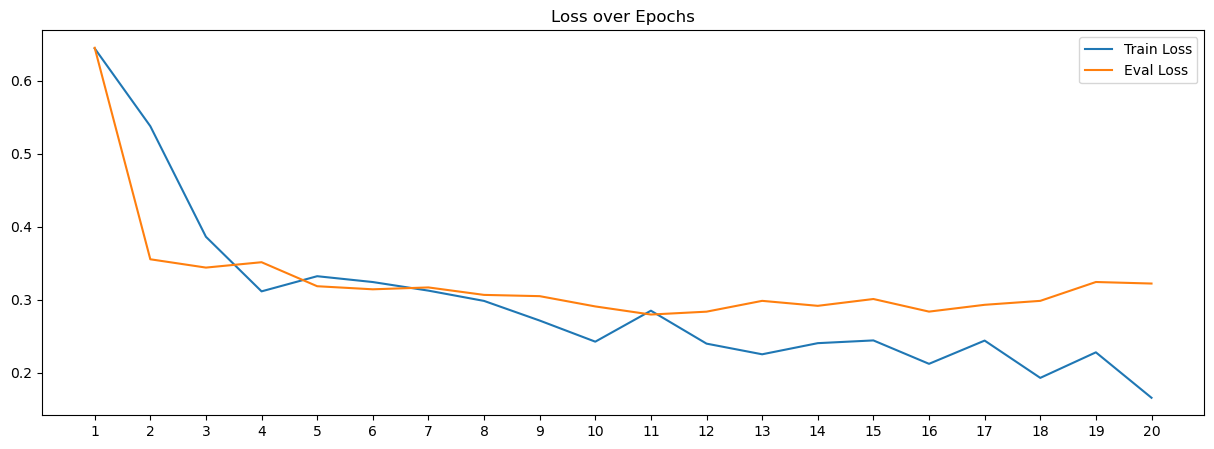

In [38]:
# Plotting training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(np.arange(1, 21, 1), epoch_train_loss, label='Train Loss')
plt.plot(np.arange(1, 21, 1), epoch_eval_loss, label='Eval Loss')
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.title('Loss over Epochs')
plt.show();

### Загрузим лучшую сохраненную модель

In [40]:
#loading the best saved model
path = model.name_or_path.split('/')[1]+'.saved.weights.pt'
path

'ruT5-base.saved.weights.pt'

In [41]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [42]:
model.to(device)

T5ForSequenceClassification(
  (transformer): T5Model(
    (shared): Embedding(32128, 768)
    (encoder): T5Stack(
      (embed_tokens): Embedding(32128, 768)
      (block): ModuleList(
        (0): T5Block(
          (layer): ModuleList(
            (0): T5LayerSelfAttention(
              (SelfAttention): T5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): T5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): T5LayerFF(
              (DenseReluDense): T5DenseActDense(
                (wi): Linear(in_features=768, out_features=3072, bias=False)
                (wo): Linear(in_feat

In [43]:
model.eval()
test_losses = []
test_preds = []
test_targets = []

for batch in tqdm(test_dataloader):
    with torch.no_grad():
            out = model(**batch.to(model.device))
    test_losses.append(out.loss.item())
    test_preds.extend(out.logits.argmax(1).tolist())
    test_targets.extend(batch['labels'].tolist())

print('Eval Loss', np.mean(test_losses), 'Accuracy', np.mean(np.array(test_targets) == test_preds))

  0%|          | 0/53 [00:00<?, ?it/s]

Eval Loss 0.23466452016969616 Accuracy 0.9304556354916067


In [44]:
accuracy_score(test_targets, test_preds)

0.9304556354916067

In [45]:
confusion_matrix(test_targets, test_preds)

array([[ 69,   1,   4],
       [ 10,   1,   8],
       [  6,   0, 318]])

### Создадим процедуру для оценки модели

In [47]:
results = {}

In [48]:
def get_model_results(etime, vloss, dataloader, model):
    """
        etime: List of accumulated train time for each epoch;
        vloss: List of validation losses for each epoch;
        dataloader: Dataloader for model; 
        model: Model to test;
    """
    # количество эпох до достижения минимального значения loss на валидационной выборке,
    min_epoch_num = vloss.index(min(vloss))
    #общее время дообучения
    total_train_time = etime[min_epoch_num]
    #время, затрачиваемое на одну итерацию обучения
    avg_train_step_time = etime[-1]/len(etime)

    model.eval()
    test_losses = []
    test_preds = []
    test_targets = []
    
    for batch in tqdm(test_dataloader):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        test_losses.append(out.loss.item())
        test_preds.extend(out.logits.argmax(1).tolist())
        test_targets.extend(batch['labels'].tolist())
    
    accuracy_metric = np.mean(np.array(test_targets) == test_preds)

    print(f"min_epoch: {min_epoch_num+1}, epoch_time: {avg_train_step_time}, total_train_time: {total_train_time}, accuracy: {accuracy_metric}")
    return [min_epoch_num+1, round(avg_train_step_time, 2), round(total_train_time, 2), round(accuracy_metric,4)]    

In [49]:
get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/53 [00:00<?, ?it/s]

min_epoch: 11, epoch_time: 47.142826282978056, total_train_time: 523.4105961322784, accuracy: 0.9304556354916067


[11, 47.14, 523.41, 0.9305]

**Сохраним результаты**

In [51]:
results[model.name_or_path.split('/')[1]] = get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/53 [00:00<?, ?it/s]

min_epoch: 11, epoch_time: 47.142826282978056, total_train_time: 523.4105961322784, accuracy: 0.9304556354916067


In [52]:
pd.DataFrame(results, index=['Epoch num','Epoch avg time','Total train time','Accuracy']).T

,Epoch num,Epoch avg time,Total train time,Accuracy
ruT5-base,11.0,47.14,523.41,0.9305


## 2.2 Google/mT5-base

In [54]:
base_model = 'google/mt5-base'

In [55]:
tokenizer = AutoTokenizer.from_pretrained(base_model)
tokenizer

T5TokenizerFast(name_or_path='google/mt5-base', vocab_size=250100, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'eos_token': '</s>', 'unk_token': '<unk>', 'pad_token': '<pad>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	250000: AddedToken("▁<extra_id_99>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	250001: AddedToken("▁<extra_id_98>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	250002: AddedToken("▁<extra_id_97>", rstrip=False, lstrip=False, single_word=False, normalized=False, special=False),
	250003: Adde

In [56]:
data_tokenized = data.map(lambda x: tokenizer(x['text'], truncation=True, max_length=512), batched=True, remove_columns=['text'])
data_tokenized

Map:   0%|          | 0/1943 [00:00<?, ? examples/s]

Map:   0%|          | 0/416 [00:00<?, ? examples/s]

Map:   0%|          | 0/417 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1943
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 416
    })
    test: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 417
    })
})

In [57]:
print(data_tokenized['train'][0])

{'label': 2, 'input_ids': [11378, 66587, 1965, 6682, 86685, 308, 315, 2527, 507, 374, 197306, 507, 38458, 324, 34788, 433, 259, 260, 1213, 259, 260, 259, 173013, 259, 45253, 315, 16859, 2738, 259, 15631, 315, 12643, 2738, 4278, 324, 259, 260, 18819, 38458, 805, 38072, 324, 315, 5107, 26126, 259, 4150, 259, 411, 3752, 507, 259, 279, 259, 279, 220289, 7077, 259, 260, 635, 38458, 324, 5608, 259, 63131, 308, 388, 425, 106923, 84778, 9894, 8050, 259, 42850, 78883, 259, 261, 2021, 1431, 3206, 20253, 30468, 1348, 259, 4150, 310, 37935, 3330, 259, 279, 259, 131924, 5870, 259, 261, 12643, 3053, 11121, 259, 735, 6682, 54310, 259, 279, 259, 735, 13324, 1035, 36916, 1454, 154354, 49995, 688, 62032, 191830, 54896, 140724, 259, 9249, 44616, 324, 1498, 1011, 32550, 817, 446, 2934, 259, 260, 81622, 1431, 60357, 259, 261, 75376, 259, 185407, 9273, 259, 48940, 259, 261, 34298, 1431, 1182, 73939, 259, 279, 778, 24816, 1066, 259, 264, 313, 2553, 24911, 558, 313, 259, 261, 4177, 893, 15541, 308, 401, 259, 

In [58]:
collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [59]:
train_dataloader = DataLoader(data_tokenized['train'], shuffle=True, batch_size=4, collate_fn=collator)
val_dataloader = DataLoader(data_tokenized['validation'], shuffle=False, batch_size=4, collate_fn=collator)
test_dataloader = DataLoader(data_tokenized['test'], shuffle=False, batch_size=4, collate_fn=collator)

In [60]:
model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=3)
model

Some weights of MT5ForSequenceClassification were not initialized from the model checkpoint at google/mt5-base and are newly initialized: ['classification_head.dense.bias', 'classification_head.dense.weight', 'classification_head.out_proj.bias', 'classification_head.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


MT5ForSequenceClassification(
  (transformer): MT5Model(
    (shared): Embedding(250112, 768)
    (encoder): MT5Stack(
      (embed_tokens): Embedding(250112, 768)
      (block): ModuleList(
        (0): MT5Block(
          (layer): ModuleList(
            (0): MT5LayerSelfAttention(
              (SelfAttention): MT5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): MT5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): MT5LayerFF(
              (DenseReluDense): MT5DenseGatedActDense(
                (wi_0): Linear(in_features=768, out_features=2048, bias=False)
                (w

In [61]:
model.to(device)

MT5ForSequenceClassification(
  (transformer): MT5Model(
    (shared): Embedding(250112, 768)
    (encoder): MT5Stack(
      (embed_tokens): Embedding(250112, 768)
      (block): ModuleList(
        (0): MT5Block(
          (layer): ModuleList(
            (0): MT5LayerSelfAttention(
              (SelfAttention): MT5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): MT5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): MT5LayerFF(
              (DenseReluDense): MT5DenseGatedActDense(
                (wi_0): Linear(in_features=768, out_features=2048, bias=False)
                (w

In [62]:
optimizer = Adam(model.parameters(), lr=1e-6)  #LR should be in balance with batch size
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 1e-06
    maximize: False
    weight_decay: 0
)

In [63]:
gc.collect()
torch.cuda.empty_cache()

In [64]:
# seting initial best loss to infinite
best_eval_loss = float('inf')

losses = []
epoch_train_loss = []
epoch_eval_loss = []
epoch_train_time = []
train_time = []
start = time.time()
for epoch in trange(20):
    pbar = tqdm(train_dataloader)
    model.train()
    for i, batch in enumerate(pbar):
        out = model(**batch.to(model.device))
        out.loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses.append(out.loss.item())
        train_time.append(time.time() - start)
        pbar.set_description(f'loss: {np.mean(losses[-100:]):2.2f}')
    epoch_train_loss.append(np.mean(losses[-100:]))

    model.eval()
    eval_losses = []
    eval_preds = []
    eval_targets = []
    val_time = []
    for batch in tqdm(val_dataloader):
        with torch.no_grad():
                out = model(**batch.to(model.device))
        eval_losses.append(out.loss.item())
        eval_preds.extend(out.logits.argmax(1).tolist())
        eval_targets.extend(batch['labels'].tolist())
        val_time.append(time.time() - start)
    epoch_eval_loss.append(np.mean(eval_losses))
    epoch_train_time.append(elapsed := time.time() - start)
    val_loss = np.mean(eval_losses)
    print('Epoch:', epoch+1, 'Train Loss', np.mean(losses[-100:]), 'Eval Loss', val_loss, 'Accuracy', np.mean(np.array(eval_targets) == eval_preds), 'Time:', elapsed)

    #save the best model
    if val_loss < best_eval_loss:
        best_eval_loss = val_loss
        torch.save(model.state_dict(), model.name_or_path.split('/')[1]+'.saved.weights.pt')   

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/486 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/2.33G [00:00<?, ?B/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 1 Train Loss 0.8267175754904748 Eval Loss 0.7509502312884881 Accuracy 0.7740384615384616 Time: 68.43540859222412


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 2 Train Loss 0.7485820251703262 Eval Loss 0.6877117606882865 Accuracy 0.7788461538461539 Time: 138.56067776679993


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 3 Train Loss 0.6759940871596336 Eval Loss 0.6857345300511672 Accuracy 0.7764423076923077 Time: 209.19282293319702


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 4 Train Loss 0.7079225893318654 Eval Loss 0.6891757118014189 Accuracy 0.7716346153846154 Time: 279.5957565307617


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 5 Train Loss 0.6836531242728233 Eval Loss 0.6637890317405646 Accuracy 0.7764423076923077 Time: 348.7015039920807


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 6 Train Loss 0.672271479666233 Eval Loss 0.6691864412277937 Accuracy 0.7764423076923077 Time: 421.3232207298279


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 7 Train Loss 0.6546607811748981 Eval Loss 0.6639973075630573 Accuracy 0.7764423076923077 Time: 490.2601795196533


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 8 Train Loss 0.6916176941990853 Eval Loss 0.6774919071736244 Accuracy 0.7740384615384616 Time: 559.4229829311371


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 9 Train Loss 0.6159634053707123 Eval Loss 0.6757783745057308 Accuracy 0.7740384615384616 Time: 627.3559355735779


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 10 Train Loss 0.6401617175340653 Eval Loss 0.6906366187792558 Accuracy 0.7692307692307693 Time: 695.4557094573975


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 11 Train Loss 0.6463795390725136 Eval Loss 0.6739278263770617 Accuracy 0.7764423076923077 Time: 763.9453320503235


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 12 Train Loss 0.6752144794166088 Eval Loss 0.6696265739603684 Accuracy 0.7764423076923077 Time: 831.7330405712128


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 13 Train Loss 0.6823914970457554 Eval Loss 0.6680556525691197 Accuracy 0.7764423076923077 Time: 899.4483458995819


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 14 Train Loss 0.6450683531165123 Eval Loss 0.6889846436679363 Accuracy 0.7764423076923077 Time: 967.9214026927948


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 15 Train Loss 0.5713905464112758 Eval Loss 0.6884500924497843 Accuracy 0.7740384615384616 Time: 1037.421807050705


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 16 Train Loss 0.6588953261077404 Eval Loss 0.6811325082985255 Accuracy 0.7764423076923077 Time: 1106.299896478653


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 17 Train Loss 0.6361445558071136 Eval Loss 0.6897603869438171 Accuracy 0.7740384615384616 Time: 1175.9369492530823


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 18 Train Loss 0.7053435070812702 Eval Loss 0.6842268009025317 Accuracy 0.7764423076923077 Time: 1245.9872562885284


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 19 Train Loss 0.6554394634068013 Eval Loss 0.6829872800467106 Accuracy 0.7764423076923077 Time: 1313.9048597812653


  0%|          | 0/486 [00:00<?, ?it/s]

  0%|          | 0/104 [00:00<?, ?it/s]

Epoch: 20 Train Loss 0.6482466305792332 Eval Loss 0.6750994847657589 Accuracy 0.7764423076923077 Time: 1382.6968832015991


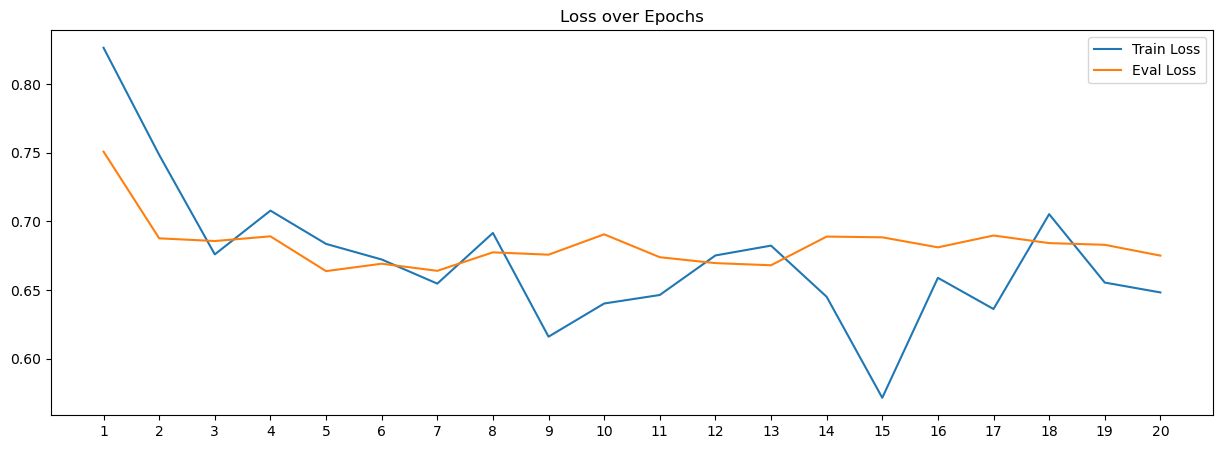

In [65]:
# Plotting training and validation loss
plt.figure(figsize=(15, 5))
plt.plot(np.arange(1, 21, 1), epoch_train_loss, label='Train Loss')
plt.plot(np.arange(1, 21, 1), epoch_eval_loss, label='Eval Loss')
plt.xticks(np.arange(1, 21, 1))
plt.legend()
plt.title('Loss over Epochs')
plt.show();

### Загрузим лучшую сохраненную модель

In [119]:
#loading the best saved model
path = model.name_or_path.split('/')[1]+'.saved.weights.pt'
path

'mt5-base.saved.weights.pt'

In [121]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [123]:
model.to(device)

MT5ForSequenceClassification(
  (transformer): MT5Model(
    (shared): Embedding(250112, 768)
    (encoder): MT5Stack(
      (embed_tokens): Embedding(250112, 768)
      (block): ModuleList(
        (0): MT5Block(
          (layer): ModuleList(
            (0): MT5LayerSelfAttention(
              (SelfAttention): MT5Attention(
                (q): Linear(in_features=768, out_features=768, bias=False)
                (k): Linear(in_features=768, out_features=768, bias=False)
                (v): Linear(in_features=768, out_features=768, bias=False)
                (o): Linear(in_features=768, out_features=768, bias=False)
                (relative_attention_bias): Embedding(32, 12)
              )
              (layer_norm): MT5LayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (1): MT5LayerFF(
              (DenseReluDense): MT5DenseGatedActDense(
                (wi_0): Linear(in_features=768, out_features=2048, bias=False)
                (w

### Протестируем и сохраним результаты

In [125]:
get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/105 [00:00<?, ?it/s]

min_epoch: 5, epoch_time: 69.13484416007995, total_train_time: 348.7015039920807, accuracy: 0.7793764988009593


[5, 69.13, 348.7, 0.7794]

In [127]:
results[model.name_or_path.split('/')[1]] = get_model_results(epoch_train_time, epoch_eval_loss, test_dataloader, model)

  0%|          | 0/105 [00:00<?, ?it/s]

min_epoch: 5, epoch_time: 69.13484416007995, total_train_time: 348.7015039920807, accuracy: 0.7793764988009593


In [129]:
pd.DataFrame(results, index=['Epoch num','Epoch avg time','Total train time','Accuracy']).T

,Epoch num,Epoch avg time,Total train time,Accuracy
ruT5-base,11.0,47.14,523.41,0.9305
mt5-base,5.0,69.13,348.70,0.7794


## 3. Анализ результатов

Итоговые результаты

In [131]:
pd.DataFrame(results, index = ['Epoch num','Epoch avg time','Total train time','Accuracy']).T.sort_values(by=['Accuracy'], ascending=False)

,Epoch num,Epoch avg time,Total train time,Accuracy
ruT5-base,11.0,47.14,523.41,0.9305
mt5-base,5.0,69.13,348.70,0.7794


- На первом месте, с огромным отрывом - ruT5-base, специализированная модель для русского языка;
- Модель от Google практически отказалась обучаться, пробовал tiny и base варианты, результаты идентичны. Возможно, для обучения данной модели нужен более объемный набор данных;

Из полученных результатов, на мой взгляд, можно сделать следующий основной вывод - предобучение модели на целевом языке/корпусе текстов критично важно для получения высоких результатов.  